# Player - Ground contact image classification - training

In [1]:
import os
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import matthews_corrcoef

## Load Data

In [2]:
DATASET_DIR = "dataset"

# train labels
train_labels_df =  pd.read_csv(os.path.join(DATASET_DIR, "train_labels.csv"), 
                               parse_dates=["datetime"])

# contact reduced to p2p distance below threshold
train_contact_df_reduced = pd.read_csv(os.path.join(DATASET_DIR, "train_contact_df_reduced.csv"))

# contact image
contact_image_endzone_df = pd.read_csv(os.path.join(DATASET_DIR, "train_contact_image_endzone_df.csv"))

## The PlayerContact dataset

### Transform function
It converts the PIL Image into a Tensor and normalizes it using the mean and std values from Imagenet

In [73]:
# transforms
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
# data augmentation for train set
image_transform_train = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(0, 45)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

image_transform_test = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

## The PlayerContact Dataset Class
The PlayerContact dataset class takes the data from the folder and returns images

In [80]:
class PlayerContactDataset(Dataset):
    """
    PlayerContact dataset that returns an image and feature vector
    """
    def __init__(self, data_dir, contact_df, view, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.contact_df = contact_df.fillna(-1) # fill nan with -1 for feature vector
        self.view = view
        
    def __getitem__(self, idx):
        # get the row
        row = self.contact_df.iloc[idx] 
        # get the image
        img_path = os.path.join(self.data_dir, row['contact_id']+'_'+self.view+'.jpg')
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image)
        
        # get feature vector
        if row['nfl_player_id_2'] == -1:
            # if ground contact, retrieve only player 1 data and no p2p distance
            feature_cols = ['x_position_1', 'y_position_1', 'speed_1', 'distance_1', 
                            'direction_1', 'orientation_1', 'acceleration_1', 'sa_1']
        else:
            feature_cols = ['x_position_1', 'y_position_1', 'speed_1', 'distance_1', 
                            'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
                            'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 
                            'direction_2', 'orientation_2', 'acceleration_2', 'sa_2',
                            'p2p_distance']
            
        feature = torch.tensor(row[feature_cols]).float()
        
        # get the class label
        label = torch.tensor(row['contact_truth'])
        
        return image, feature, label
    
    def __len__(self):
        return len(self.contact_df)

### Prepare and split the data

In [81]:
# # we want a dataset with 25% of positive contacts and 75% of negative contacts

# # merge contact_df and contact_image_df
# train_df = train_contact_df_reduced.merge(contact_image_endzone_df, 
#                                  left_on=['contact_id'], 
#                                  right_on=['contact_id'], 
#                                  how='left').drop_duplicates()
# # use only the rows where the crop was generated
# train_df = train_df[train_df['crop_generated'] == True]
# # get the ground contacts
# train_df = train_df[train_df['nfl_player_id_2'] == -1]

# # get all positive contacts
# pos_df = train_df[train_df['contact_truth'] == 1]
# num_pos = len(pos_df)

# # retrieve a number of negative contacts = to 3 times the number of positive contacts
# neg_df = train_df[train_df['contact_truth'] == 0].sample(3*num_pos, random_state=42)
# # concatenate negative and positive contacts
# train_df = pd.concat([pos_df, neg_df])

# # train test split
# train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# train_df

In [82]:
# merge contact_df and contact_image_df
train_df = train_contact_df_reduced.merge(contact_image_endzone_df, 
                                 left_on=['contact_id'], 
                                 right_on=['contact_id'], 
                                 how='left').drop_duplicates()
# use only the rows where the crop was generated
train_df = train_df[train_df['crop_generated'] == True]
# get the ground contacts
train_df = train_df[train_df['nfl_player_id_2'] == -1]

# split the dataset
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df

,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,datetime,team_1,position_1,...,orientation_2,acceleration_2,sa_2,p2p_distance,contact_truth,contact,crop_generated,rewinded_frames,miss_helmet_dets,miss_player_dets
150383,58224_000998_42_40151_G,58224_000998,42,40151,-1,58224,998,2020-10-04 17:46:54.100000+00:00,home,C,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
74850,58202_000170_20_47952_G,58202_000170,20,47952,-1,58202,170,2020-09-27 17:06:46.200000+00:00,away,T,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
199133,58257_003529_5_43459_G,58257_003529,5,43459,-1,58257,3529,2020-11-22 23:32:48.400000+00:00,home,C,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
91184,58204_000790_63_46226_G,58204_000790,63,46226,-1,58204,790,2020-09-27 17:34:05.700000+00:00,home,TE,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
627734,58567_004074_18_52607_G,58567_004074,18,52607,-1,58567,4074,2021-10-08 03:27:16.100000+00:00,away,SS,...,0.0,0.0,0.0,999.0,0,0,True,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246479,58285_004176_5_43338_G,58285_004176,5,43338,-1,58285,4176,2020-11-02 00:22:24.800000+00:00,home,DT,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
525572,58528_000317_20_46084_G,58528_000317,20,46084,-1,58528,317,2021-09-19 17:15:20.100000+00:00,away,T,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
269053,58301_000786_61_48097_G,58301_000786,61,48097,-1,58301,786,2020-11-10 01:48:23.600000+00:00,away,WR,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
300956,58311_002159_112_43475_G,58311_002159,112,43475,-1,58311,2159,2020-10-18 21:50:37.200000+00:00,home,WR,...,0.0,0.0,0.0,999.0,1,1,True,0.0,0.0,0.0


In [83]:
num_contacts = train_df['contact_truth'].sum()
print(f"There are {num_contacts} positive contacts with the ground in the train set")
print(f"{num_contacts / len(train_df)*100:.2f}% of contacts with the ground are positive on the train set")

There are 13060 positive contacts with the ground in the train set
5.02% of contacts with the ground are positive on the train set


### Create instance of the dataset specific to player-ground contact

In [84]:
DATA_PATH = os.path.join('dataset', 'train', 'crops')
# train
p_g_contact_dataset_train = PlayerContactDataset(DATA_PATH, train_df, 'Endzone', image_transform_train)
# test
p_g_contact_dataset_test = PlayerContactDataset(DATA_PATH, test_df, 'Endzone', image_transform_test)

### Utils to show image from dataset

In [86]:
def inverse_normalize(tensor, mean, std):
    for channel_tensor, c_mean, c_std in zip(tensor, mean, std):
        channel_tensor.mul_(c_std).add_(c_mean)
        # The normalize code -> channel_tensor.sub_(c_mean).div_(c_std)
        
    return tensor

def tensor_to_image(tensor, is_normalized=True):
    img = tensor
    if is_normalized:
        img = inverse_normalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    img = np.array(img).transpose(1, 2, 0)
    img = Image.fromarray((img*255).astype(np.uint8))
    
    return img

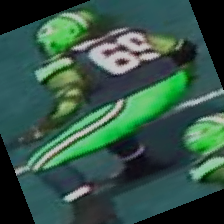

In [87]:
tensor_to_image(p_g_contact_dataset_train[700][0])

### Data Loaders

In [88]:
BATCH_SIZE = 32

loader_train = DataLoader(p_g_contact_dataset_train,
                         batch_size=BATCH_SIZE,
                         shuffle=True, 
                         num_workers=0,
                         drop_last=True) # drop last batch with size < 8 so that the batchnorm layers dont fail

loader_test = DataLoader(p_g_contact_dataset_test,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         drop_last=False)

In [90]:
# get one batch
images, features, labels = next(iter(loader_train))
# check the batch size
print(f'Batch size: {len(images)}')
print(f'Image shape: {images.shape}')
print(f'feature shape: {features.shape}')
print(f'labels shape: {labels.shape}')

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
feature shape: torch.Size([32, 8])
labels shape: torch.Size([32])


## Load the efficientnet model with no classification head

In [91]:
def get_efficientnet_model(pretrained=True, fine_tune=True):
    """
    Returns en efficientnetB0 model that retturns the flattenned feature
    """
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        for params in model.parameters():
            params.requires_grad = False
            
    # Replace the final classification head with a flatten layer
    model.classifier = nn.Flatten()
            
    return model

## The multi input model

In [92]:
class ContactMultiInputNetwork(nn.Module):
    def __init__(self, num_classes=1, num_features=8):
        super(ContactMultiInputNetwork, self).__init__()
        self.efficientnet = get_efficientnet_model()
        
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(1536, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        # x[0] contains the image tensor and x[1] the feature vector tensor
        img_feature = self.efficientnet(x[0])
        # shape = (batch_size, 1280)
        x = F.relu(self.bn1(self.fc1(x[1])))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        # shape = (batch_size, 256)
        # concatenate image and vector features
        x = torch.cat([img_feature, x], dim=1)
        # shape = (batch_size, 1536)
        # final classification
        x = self.fc3(x)
        # shape = (batch_size, 1)
        
        return x

In [93]:
# 1 class for binary output
# feature vector has size 8
model = ContactMultiInputNetwork(num_classes=1, num_features=8) 

C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training

### Training Utils

In [94]:
class Averager():
    """
    An Averager keeps track of the training and validation loss values
    and helps to get the average for each epoch as well
    """
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [95]:
def save_loss_plot(output_dir, mean_train_loss, mean_valid_loss, epoch_num, model_name):
    """
    Save plots with the loss curves of the model training
    """
    fig, ax = plt.subplots(figsize=(15,10))

    ax.plot(np.arange(epoch_num)+1, mean_train_loss, label='Training loss')
    ax.plot(np.arange(epoch_num)+1, mean_valid_loss, label='Validation Loss')
    
    ax.set_xticks(np.arange(1, epoch_num+1, step=1))
    if (epoch_num > 20):
        ax.set_xticks(np.arange(0, epoch_num+1, step=2))
    if(epoch_num > 50):
        ax.set_xticks(np.arange(0, epoch_num+1, step=5))
    if(epoch_num > 100):
        ax.set_xticks(np.arange(0, epoch_num+1, step=10))
    if(epoch_num > 1000):
        ax.set_xticks(np.arange(0, epoch_num+1, step=100))
        
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.set_title('Loss Curves')
    ax.legend()
    fig.savefig(f"{output_dir}/{model_name}_epoch_loss.png")

    print('SAVING PLOTS COMPLETE...')

    plt.close('all')

In [96]:
def save_model(epoch, model, optimizer, model_name='model', out_dir='.'):
    """
    Function to save the trained model
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{out_dir}/{model_name}.pth')

    
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), model_name='model'
    ):
        self.best_valid_loss = best_valid_loss
        self.non_improve_iters = 0
        self.model_name = model_name
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, out_dir='.'
    ):
        if current_valid_loss < self.best_valid_loss:
            self.non_improve_iters = 0
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            model_name = f'bm_{self.model_name}_epoch_{epoch+1}'
            save_model(epoch, model, optimizer, model_name, out_dir)
        else:
            self.non_improve_iters += 1

### Training 1 epoch

In [97]:
def train_one_epoch(model, data_loader, criterion, optimizer, device, train_loss_averager):
    """
    Function that trains the given model for one epoch 
    with the given data loader
    """
    # activate model training mode in case its in evaluation mode
    model.train()
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    for i, (img_data, feature_data, labels) in enumerate(prog_bar):
        # send data to device
        img_data = img_data.to(device)
        feature_data = feature_data.to(device)
        labels = labels.to(device).to(torch.float32)
        # reset the gradient accummulation from the previous batch
        optimizer.zero_grad()
        # make a prediction with the model
        prediction = model([img_data, feature_data]).to(torch.float32).squeeze(dim=1)
        # compute the loss 
        loss = criterion(prediction, labels)
        # save loss values to the averaher
        train_loss_averager.send(loss.item())
        # backpropagate the loss gradient
        loss.backward()
        # uptade parameters
        optimizer.step()

        # print the mean batch loss at each iteration
        prog_bar.set_description(desc=f"Training Loss: {train_loss_averager.value:.4f}")

### Validate Function

In [98]:
def validate_model(model, data_loader, criterion, device, val_loss_averager):
    """
    Uses the model on all the data from the data loader and 
    returns the predictions and the true targets. It also updates
    the loss averager
    """
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    loss_list = np.array([])
    total_predictions = torch.tensor([]).to(device)
    total_target_labels = torch.tensor([]).to(device)
    
    for i, (img_data, feature_data, labels) in enumerate(prog_bar):
        # send data to device
        img_data = img_data.to(device)
        feature_data = feature_data.to(device)
        labels = labels.to(device).to(torch.float32)
        # make a prediction with the model in evaluation mode
        with torch.no_grad():
            # activate evaluation mode for batchnorm layers
            model.eval()
            prediction = model([img_data, feature_data]).to(torch.float32).squeeze(dim=1)

        # add batch predictions and true labels to total lists
        total_predictions = torch.cat((total_predictions, prediction), dim=0)    
        total_target_labels = torch.cat((total_target_labels, labels), dim=0)    
        # compute the loss 
        loss = criterion(prediction, labels)
        # update loss averager
        val_loss_averager.send(loss.item())
        
        # print the mean batch loss at each iteration
        prog_bar.set_description(desc=f"Validation Loss: {val_loss_averager.value:.4f}")

    # return total predictions and total true_labels
    return total_predictions, total_target_labels

In [99]:
def get_pos_weight(train_df):
    """
    Returns a positive class weight equal to n_negative_contact / n_positive contact
    this way, the positive contacts will have more weight in the loss function
    """
    num_pos_contacts = train_df['contact_truth'].sum()
    num_neg_contacts = len(train_df) - num_pos_contacts
    pos_weight = torch.tensor([num_neg_contacts / num_pos_contacts])
    
    return pos_weight

### Constants

In [100]:
CLASSES = ['0', '1']
# detect the device (GPU or CPU)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# set the number of epochs
EPOCHS = 100
# set the learning rate
LR = 0.0001
# maximum iterations with no validation set improvement until early stoping
EARLY_STOP= 5

MODEL_NAME = 'multi_efficientnet_CLS_ground_v1'
MODEL_DIR = 'trained_models'
PLOT_DIR = 'training_plots'

!mkdir {MODEL_DIR}
!mkdir {PLOT_DIR}

A subdirectory or file trained_models already exists.
A subdirectory or file training_plots already exists.


### Main training loop

In [101]:
# TRAINING PARAMS
# initialize model and send to device
model = ContactMultiInputNetwork(num_classes=1, num_features=8)  # 1 output for binary prediction
model = model.to(DEVICE)
# initialize Adam optimizer with default parameters (like the paper)
optimizer = Adam(model.parameters(), lr=LR)
# so it halves the learning rate every 5 epochs
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0, total_iters=EPOCHS)
# initialize loss function (sigmoid + binary cross entropy)
# set a positive class weight equal to n_negative_contact / n_positive contact
# this way, the positive contacts will have more weight in the loss function
pos_weight = get_pos_weight(train_df).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

# initialize the loss Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
# initialize SaveBestModel class
save_best_model = SaveBestModel(model_name=MODEL_NAME)
# mean losses for train and validation at every epoch
mean_train_losses = []
mean_validation_losses = []

# epoch loop
for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}")
    # reset the training and valitation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start timer and carry out training and evaluation
    start = time.time()
    # train one epoch
    train_one_epoch(model, loader_train, criterion, optimizer, 
                    DEVICE, train_loss_hist)
    # update the lr scheduler
    scheduler.step()
    #evaluate the model
    y_pred, y_true = validate_model(model, loader_test, criterion,
                                    DEVICE, val_loss_hist)
    
    print(f"Epoch #{epoch+1} train_loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation_loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {(end - start):.3f} seconds for epoch {epoch+1}")

    # save the mean train and validation losses of this epoch
    mean_train_losses.append(train_loss_hist.value)
    mean_validation_losses.append(val_loss_hist.value)

    # save the best model until now if we have the minimum val loss this epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer, 
                    out_dir=MODEL_DIR)
    
    #save the current epoch model
    save_model(epoch, model, optimizer, model_name=MODEL_NAME,
               out_dir=MODEL_DIR)

    #save the loss plot
    save_loss_plot('training_plots', mean_train_losses, mean_validation_losses, 
                   epoch+1, MODEL_NAME)
    print('\n')

print('Training done')

Starting epoch 1


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #1 train_loss: 0.757
Epoch #1 validation_loss: 0.559
Took 4206.669 seconds for epoch 1

Best validation loss: 0.5587886241830398

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...


Starting epoch 2


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #2 train_loss: 0.598
Epoch #2 validation_loss: 0.519
Took 4089.144 seconds for epoch 2

Best validation loss: 0.5186229838718937

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...


Starting epoch 3


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #3 train_loss: 0.555
Epoch #3 validation_loss: 0.519
Took 2859.059 seconds for epoch 3
SAVING PLOTS COMPLETE...


Starting epoch 4


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #4 train_loss: 0.528
Epoch #4 validation_loss: 0.474
Took 2849.162 seconds for epoch 4

Best validation loss: 0.4738394722041976

Saving best model for epoch: 4

SAVING PLOTS COMPLETE...


Starting epoch 5


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #5 train_loss: 0.499
Epoch #5 validation_loss: 0.478
Took 2833.443 seconds for epoch 5
SAVING PLOTS COMPLETE...


Starting epoch 6


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #6 train_loss: 0.484
Epoch #6 validation_loss: 0.438
Took 2786.781 seconds for epoch 6

Best validation loss: 0.43771740046008667

Saving best model for epoch: 6

SAVING PLOTS COMPLETE...


Starting epoch 7


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #7 train_loss: 0.461
Epoch #7 validation_loss: 0.433
Took 2827.160 seconds for epoch 7

Best validation loss: 0.4333574230440485

Saving best model for epoch: 7

SAVING PLOTS COMPLETE...


Starting epoch 8


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #8 train_loss: 0.437
Epoch #8 validation_loss: 0.428
Took 2832.551 seconds for epoch 8

Best validation loss: 0.4283319549544348

Saving best model for epoch: 8

SAVING PLOTS COMPLETE...


Starting epoch 9


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #9 train_loss: 0.426
Epoch #9 validation_loss: 0.402
Took 2784.410 seconds for epoch 9

Best validation loss: 0.4022769719212001

Saving best model for epoch: 9

SAVING PLOTS COMPLETE...


Starting epoch 10


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #10 train_loss: 0.410
Epoch #10 validation_loss: 0.435
Took 2815.794 seconds for epoch 10
SAVING PLOTS COMPLETE...


Starting epoch 11


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #11 train_loss: 0.396
Epoch #11 validation_loss: 0.392
Took 2824.074 seconds for epoch 11

Best validation loss: 0.3923560434991775

Saving best model for epoch: 11

SAVING PLOTS COMPLETE...


Starting epoch 12


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #12 train_loss: 0.383
Epoch #12 validation_loss: 0.450
Took 2829.315 seconds for epoch 12
SAVING PLOTS COMPLETE...


Starting epoch 13


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #13 train_loss: 0.365
Epoch #13 validation_loss: 0.408
Took 2803.137 seconds for epoch 13
SAVING PLOTS COMPLETE...


Starting epoch 14


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #14 train_loss: 0.357
Epoch #14 validation_loss: 0.372
Took 2821.861 seconds for epoch 14

Best validation loss: 0.3722718887615617

Saving best model for epoch: 14

SAVING PLOTS COMPLETE...


Starting epoch 15


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #15 train_loss: 0.349
Epoch #15 validation_loss: 0.420
Took 2817.624 seconds for epoch 15
SAVING PLOTS COMPLETE...


Starting epoch 16


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #16 train_loss: 0.336
Epoch #16 validation_loss: 0.418
Took 2813.690 seconds for epoch 16
SAVING PLOTS COMPLETE...


Starting epoch 17


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #17 train_loss: 0.325
Epoch #17 validation_loss: 0.419
Took 2790.953 seconds for epoch 17
SAVING PLOTS COMPLETE...


Starting epoch 18


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #18 train_loss: 0.318
Epoch #18 validation_loss: 0.447
Took 2795.736 seconds for epoch 18
SAVING PLOTS COMPLETE...


Starting epoch 19


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #19 train_loss: 0.307
Epoch #19 validation_loss: 0.434
Took 2809.283 seconds for epoch 19
SAVING PLOTS COMPLETE...


Starting epoch 20


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #20 train_loss: 0.302
Epoch #20 validation_loss: 0.439
Took 2805.833 seconds for epoch 20
SAVING PLOTS COMPLETE...


Starting epoch 21


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #21 train_loss: 0.296
Epoch #21 validation_loss: 0.439
Took 2790.907 seconds for epoch 21
SAVING PLOTS COMPLETE...


Starting epoch 22


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #22 train_loss: 0.284
Epoch #22 validation_loss: 0.474
Took 2800.245 seconds for epoch 22
SAVING PLOTS COMPLETE...


Starting epoch 23


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #23 train_loss: 0.280
Epoch #23 validation_loss: 0.390
Took 2795.503 seconds for epoch 23
SAVING PLOTS COMPLETE...


Starting epoch 24


  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/2033 [00:00<?, ?it/s]

Epoch #24 train_loss: 0.271
Epoch #24 validation_loss: 0.475
Took 2791.995 seconds for epoch 24
SAVING PLOTS COMPLETE...


Starting epoch 25


  0%|          | 0/8130 [00:00<?, ?it/s]

KeyboardInterrupt: 

Best valid loss: 0.37227


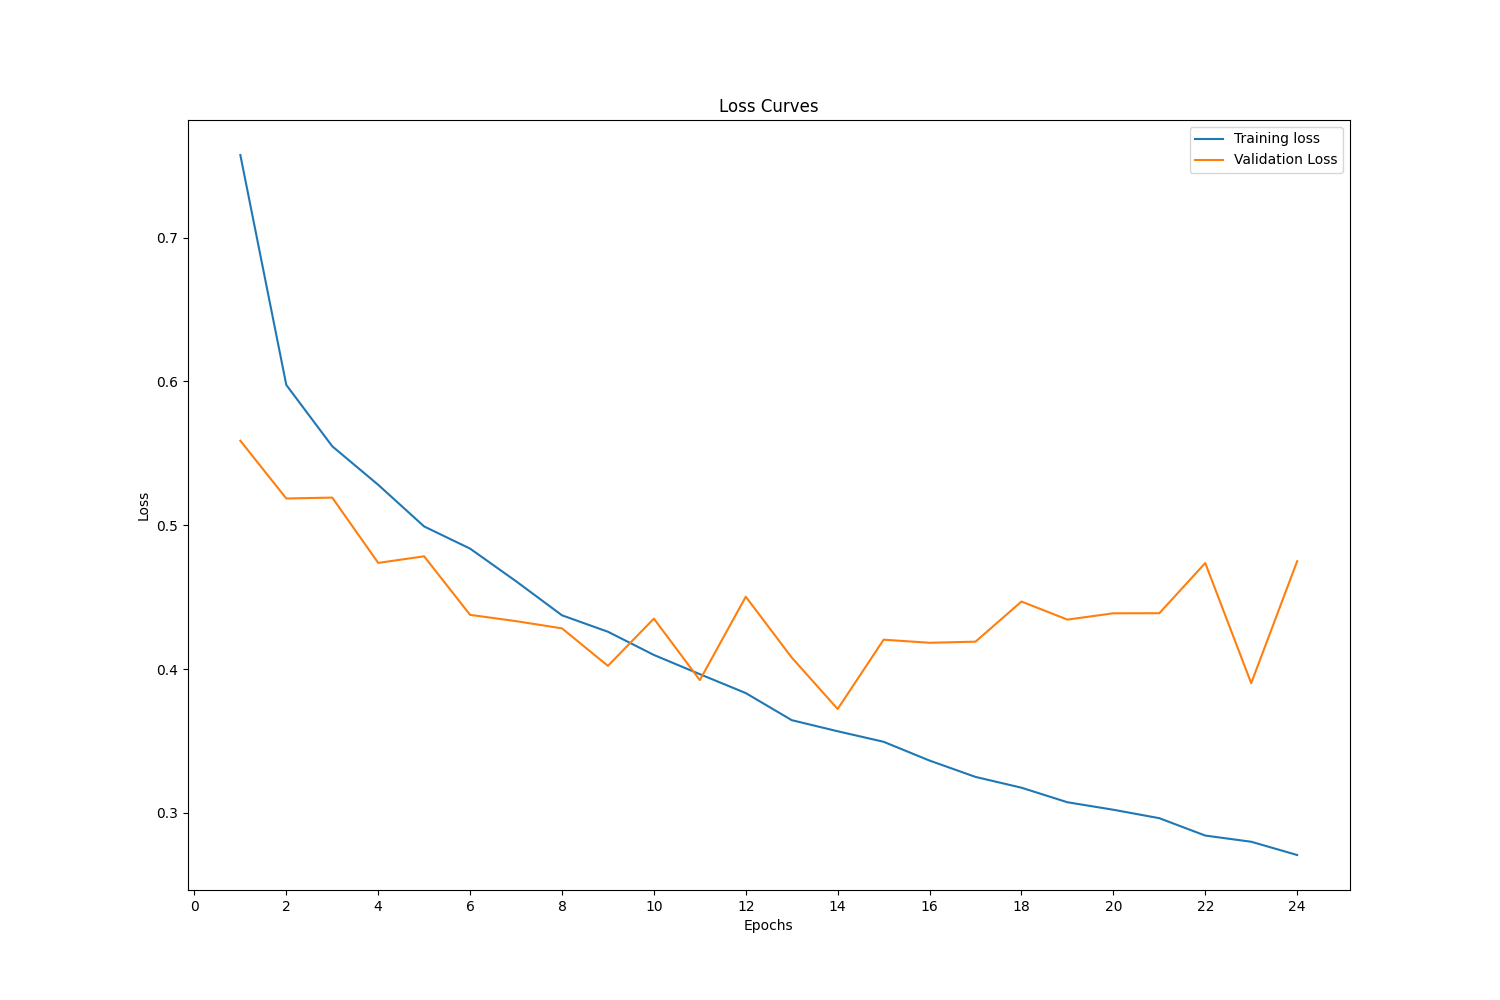

In [102]:
print(f"Best valid loss: {save_best_model.best_valid_loss:.5f}")
Image.open(f'{PLOT_DIR}/{MODEL_NAME}_epoch_loss.png')

## Check Predictions

### Load model

In [103]:
def load_model(model_path, num_classes, device, num_features):
    """
    Returns a efficientnet model with the weights from the saved model
    """
    model = ContactMultiInputNetwork(num_classes=1, num_features=num_features)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device).eval();
    
    return model

In [104]:
#load the best model on the validation set
best_model_path = os.path.join(MODEL_DIR, 'bm_multi_efficientnet_CLS_ground_v1_epoch_14.pth')
best_model = load_model(best_model_path, 1, DEVICE, num_features=8)

### Check validation set

In [105]:
val_loss_hist = Averager()
pos_weight = get_pos_weight(train_df).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
y_pred, y_true = validate_model(best_model, loader_test, criterion,
                                    DEVICE, val_loss_hist)

  0%|          | 0/2033 [00:00<?, ?it/s]

### Mathews correlation coefficient

In [106]:
# mathews correlation coefficient

thresholds = np.arange(0.0, 0.5, 0.01)
best_score = 0
best_thrs = -1
for thrs in thresholds:
    y_pred_clean = (torch.sigmoid(y_pred) > thrs).double()
    score = matthews_corrcoef(y_pred_clean.cpu(), y_true.cpu())
    if score > best_score:
        best_score = score
        best_thrs = thrs

y_pred_clean = (torch.sigmoid(y_pred) > best_thrs).double()
print(f"Best acc threshold: {best_thrs}")
print(f"Matheys corr coef: {best_score:.5f}")

Best acc threshold: 0.49
Matheys corr coef: 0.58966


### Confusion Matrix

In [107]:
def show_confusion_matrix(y_pred, y_true, display_labels, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                        display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(15,15))
    plt.title(title)
    conf_display.plot(cmap=plt.cm.Blues, ax=ax);
    return conf_matrix

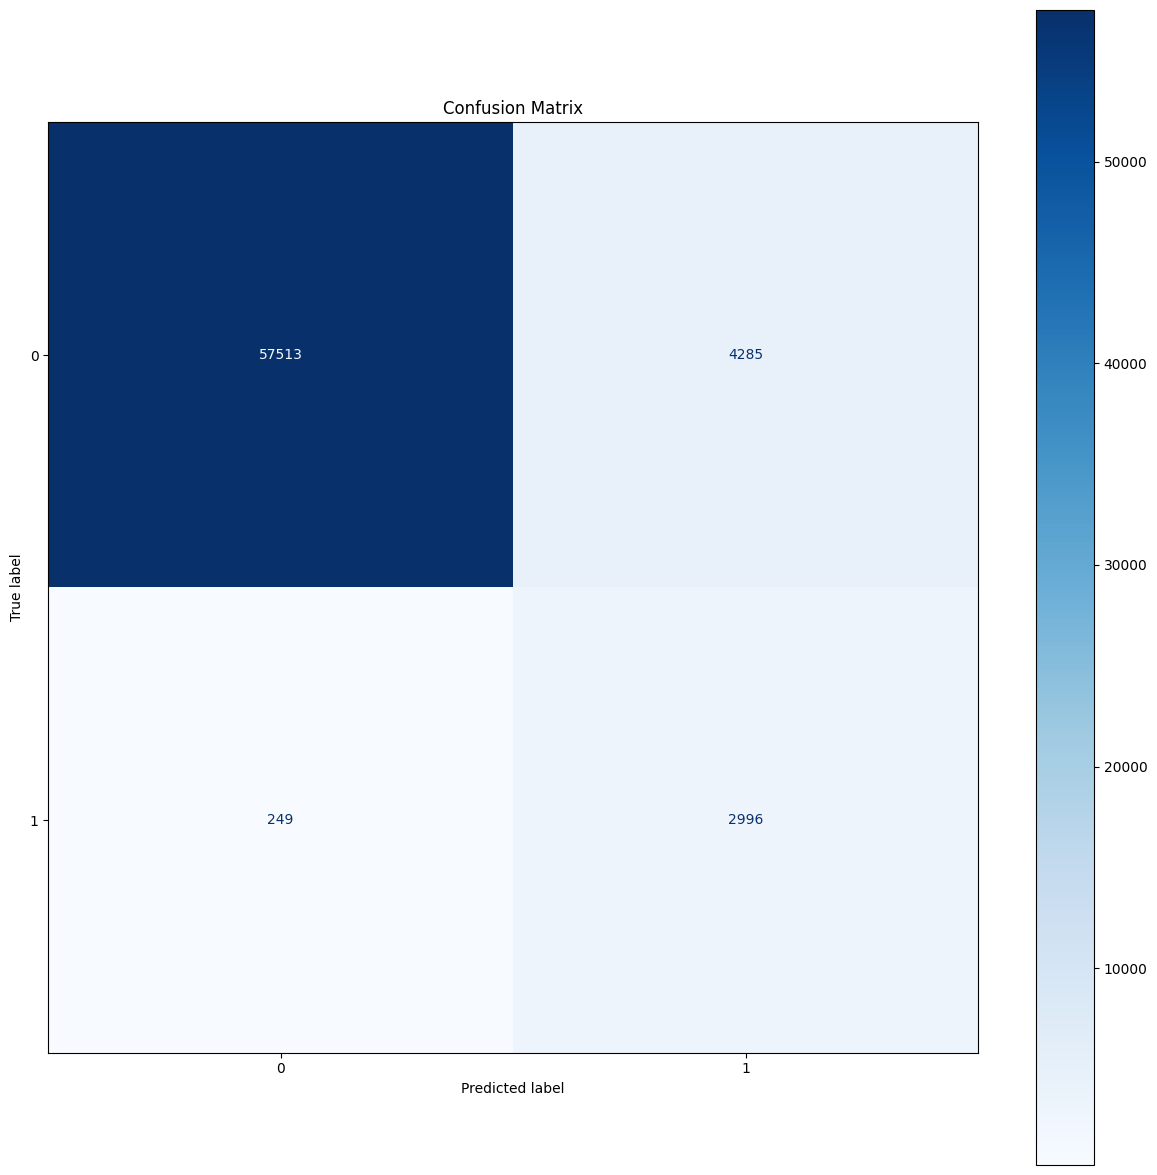

In [108]:
conf_matrix = show_confusion_matrix(y_pred_clean.cpu(), y_true.cpu(), CLASSES)

## Validate on whole dataset (ground)

In [171]:
# merge contact_df and contact_image_df
full_train_df = train_contact_df_reduced.merge(contact_image_endzone_df, 
                                 left_on=['contact_id'], 
                                 right_on=['contact_id'], 
                                 how='left').drop_duplicates()
# use only the rows where the crop was generated
full_train_df = full_train_df[full_train_df['crop_generated'] == True]
# get the ground contacts
full_train_df = full_train_df[full_train_df['nfl_player_id_2'] == -1]


full_train_df

,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,datetime,team_1,position_1,...,orientation_2,acceleration_2,sa_2,p2p_distance,contact_truth,contact,crop_generated,rewinded_frames,miss_helmet_dets,miss_player_dets
12,58168_003392_0_38590_G,58168_003392,0,38590,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
13,58168_003392_0_43854_G,58168_003392,0,43854,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,OLB,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
14,58168_003392_0_41257_G,58168_003392,0,41257,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,CB,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
15,58168_003392_0_41944_G,58168_003392,0,41944,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,DT,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
16,58168_003392_0_42386_G,58168_003392,0,42386,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,ILB,...,0.0,0.0,0.0,999.0,0,0,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660529,58582_003121_91_52493_G,58582_003121,91,52493,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,FS,...,0.0,0.0,0.0,999.0,0,0,True,10.0,0.0,0.0
660531,58582_003121_91_45287_G,58582_003121,91,45287,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,CB,...,0.0,0.0,0.0,999.0,0,0,True,10.0,0.0,0.0
660532,58582_003121_91_46105_G,58582_003121,91,46105,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,MLB,...,0.0,0.0,0.0,999.0,0,0,True,60.0,0.0,1.0
660535,58582_003121_91_52500_G,58582_003121,91,52500,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,home,WR,...,0.0,0.0,0.0,999.0,0,0,True,10.0,0.0,0.0


In [172]:
# dataset and loader
# train
p_g_contact_dataset_full = PlayerContactDataset(DATA_PATH, full_train_df, 'Endzone', image_transform_test)

loader_full = DataLoader(p_g_contact_dataset_full,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         drop_last=True)

In [173]:
# load model
best_model_path = os.path.join(MODEL_DIR, 'bm_efficientnet_CLS_ground_v6_epoch_8.pth')
best_model = load_model(best_model_path, 1, DEVICE)

C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [174]:
# inference on full dataset
val_loss_hist = Averager()
criterion = nn.BCEWithLogitsLoss()
y_pred, y_true = validate_model(best_model, loader_full, criterion,
                                    DEVICE, val_loss_hist)

  0%|          | 0/10162 [00:00<?, ?it/s]

In [175]:
# mathews correlation coefficient

thresholds = np.arange(0.0, 0.5, 0.01)
best_score = 0
best_thrs = -1
for thrs in thresholds:
    y_pred_clean = (torch.sigmoid(y_pred) > thrs).double()
    score = matthews_corrcoef(y_pred_clean.cpu(), y_true.cpu())
    if score > best_score:
        best_score = score
        best_thrs = thrs

y_pred_clean = (torch.sigmoid(y_pred) > best_thrs).double()
print(f"Best acc threshold: {best_thrs}")
print(f"Matheys corr coef: {best_score:.5f}")

Best acc threshold: 0.49
Matheys corr coef: 0.49589


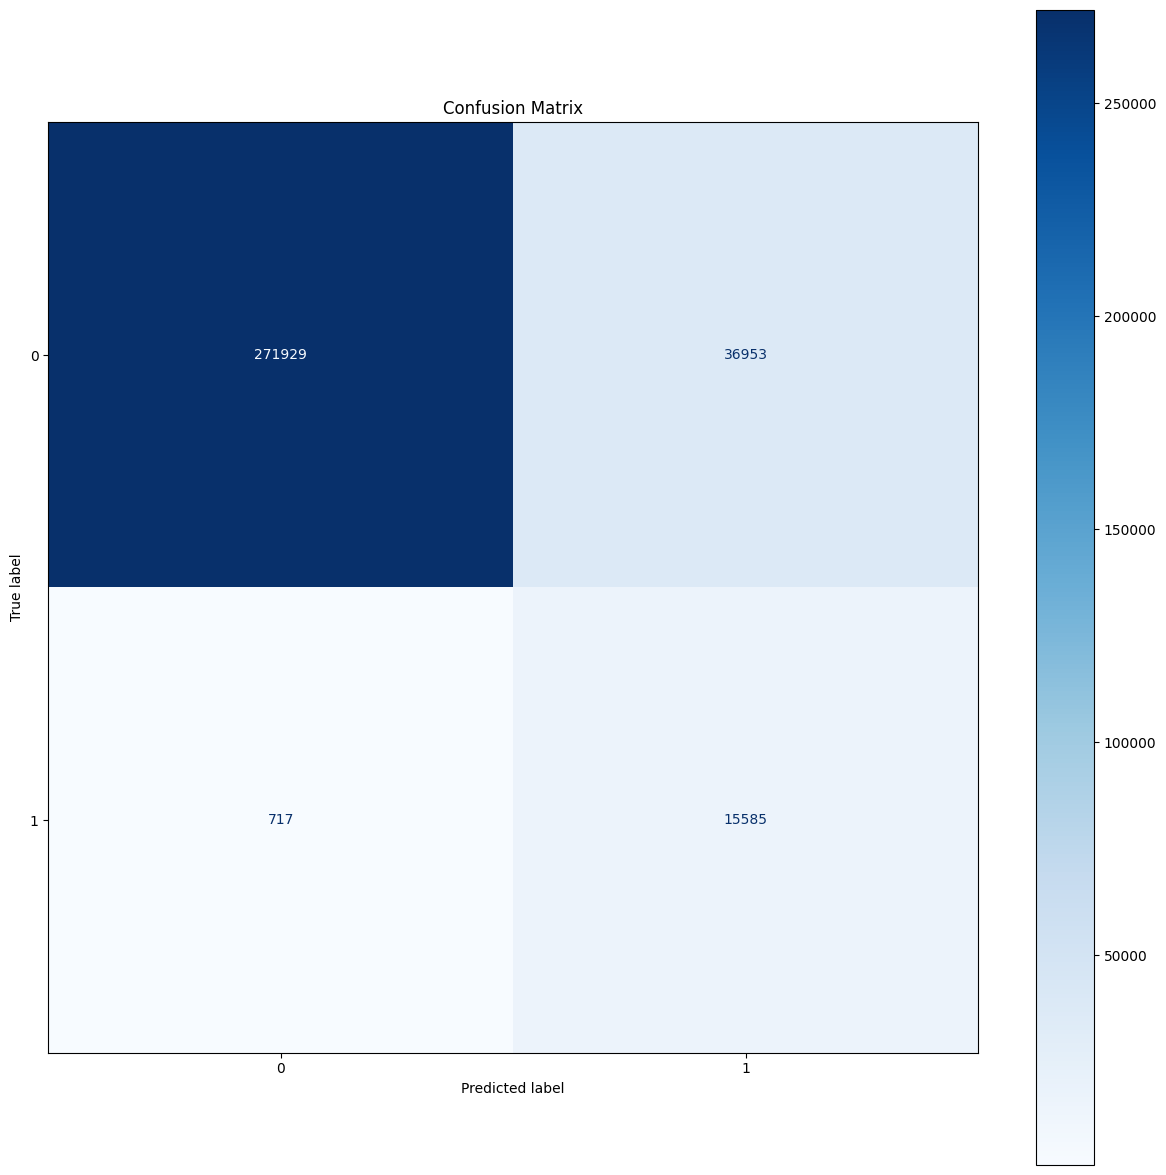

In [176]:
conf_matrix = show_confusion_matrix(y_pred_clean.cpu(), y_true.cpu(), CLASSES)